# ML Forecast (Kaggle)

In [1]:
"""
Study Material:
    https://www.kaggle.com/code/ryanholbrook/trend
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print(tf.__version__)

import os
import logging
import pandas as pd
import seaborn as sns
from datetime import datetime, date 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import sys
sys.path.append("..") # to get library file
from dateutil.relativedelta import relativedelta


import pickle
logging.basicConfig(filename="temp.log", filemode = "w", level=logging.INFO) # add filemode="w" to overwrite
from dataPull import getYfinData as getYfinData

from statsmodels.tsa.deterministic import DeterministicProcess

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression
from warnings import simplefilter
simplefilter("ignore")  # ignore warnings to clean up output cells

""" References
https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide

"""

' References\nhttps://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide\n\n'

In [2]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)



def restructData(ticker, dataObj, filter = None):
    """
    Restructure Data for Forecast Consumption

    """
    res = dataObj[ticker].copy()
    if filter is not None:
        res = res[res.date > filter]
        res.reset_index(drop = True, inplace = True)
    # Resample Data at a Monthly Level
    res = res[['date',
                'open', 
                'high',
                'low', 
                'close',
                'volume',
                'dividends',
                'stock_splits',
                'symbol',
                'load_date'
                ]].resample('M', on='date').mean().reset_index(drop=False)
    res = res.set_index('date')

    
    #res.rename(columns={'close': ticker + '_close'},inplace=True)
    res['time'] = np.arange(len(res.index)) # The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

    return res 


### Pull Data

In [3]:
# Data Pull
dataPullCfg = True
vpnFlg = True

myTicker = 'CAT'
tickerLst = ['XPO', 'BABA', 'NVDA', 'DE', 'CAT']
# requestThd = 5
dateFilt = '2021-8-15'
# getData(tickerLst, requestThd, dateFilt) # Alpha Vantage

if not vpnFlg:
    os.environ['http_proxy'] = ''
    os.environ['https_proxy'] = ''
else:
    print('Enter at a later time!')

if dataPullCfg:
    getYfinData(tickerLst, None)

# -------------------------------------------------------------------- #
# Load Data from Disk
dir = os.getcwd()
dir = dir + "\\" + "stockData.file"
with open(dir, "rb") as f:
    dump = pickle.load(f)
    print("deserialization of " + dir + " complete...")
assert len(dump) > 0, 'Check Data Pull'

Enter at a later time!
deserialization of c:\Users\malikf1\Desktop\DataScience\Local_Development\Personal_Projects\MLStockForecast\study\stockData.file complete...


### Seasonality
https://www.kaggle.com/code/ryanholbrook/seasonality

In [4]:
stockDataFrame = dump[myTicker].copy()
stockDataFrame = stockDataFrame.set_index('date')
stockDataFrame['time'] = np.arange(len(stockDataFrame.index)) # The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.

In [5]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots() # Init subplot

    palette = sns.color_palette("husl", n_colors=X[period].nunique()) # Array of rgb colors
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette, legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")

    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1] # Get last y data
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), textcoords="offset points", size=14, va="center")
    return ax



def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


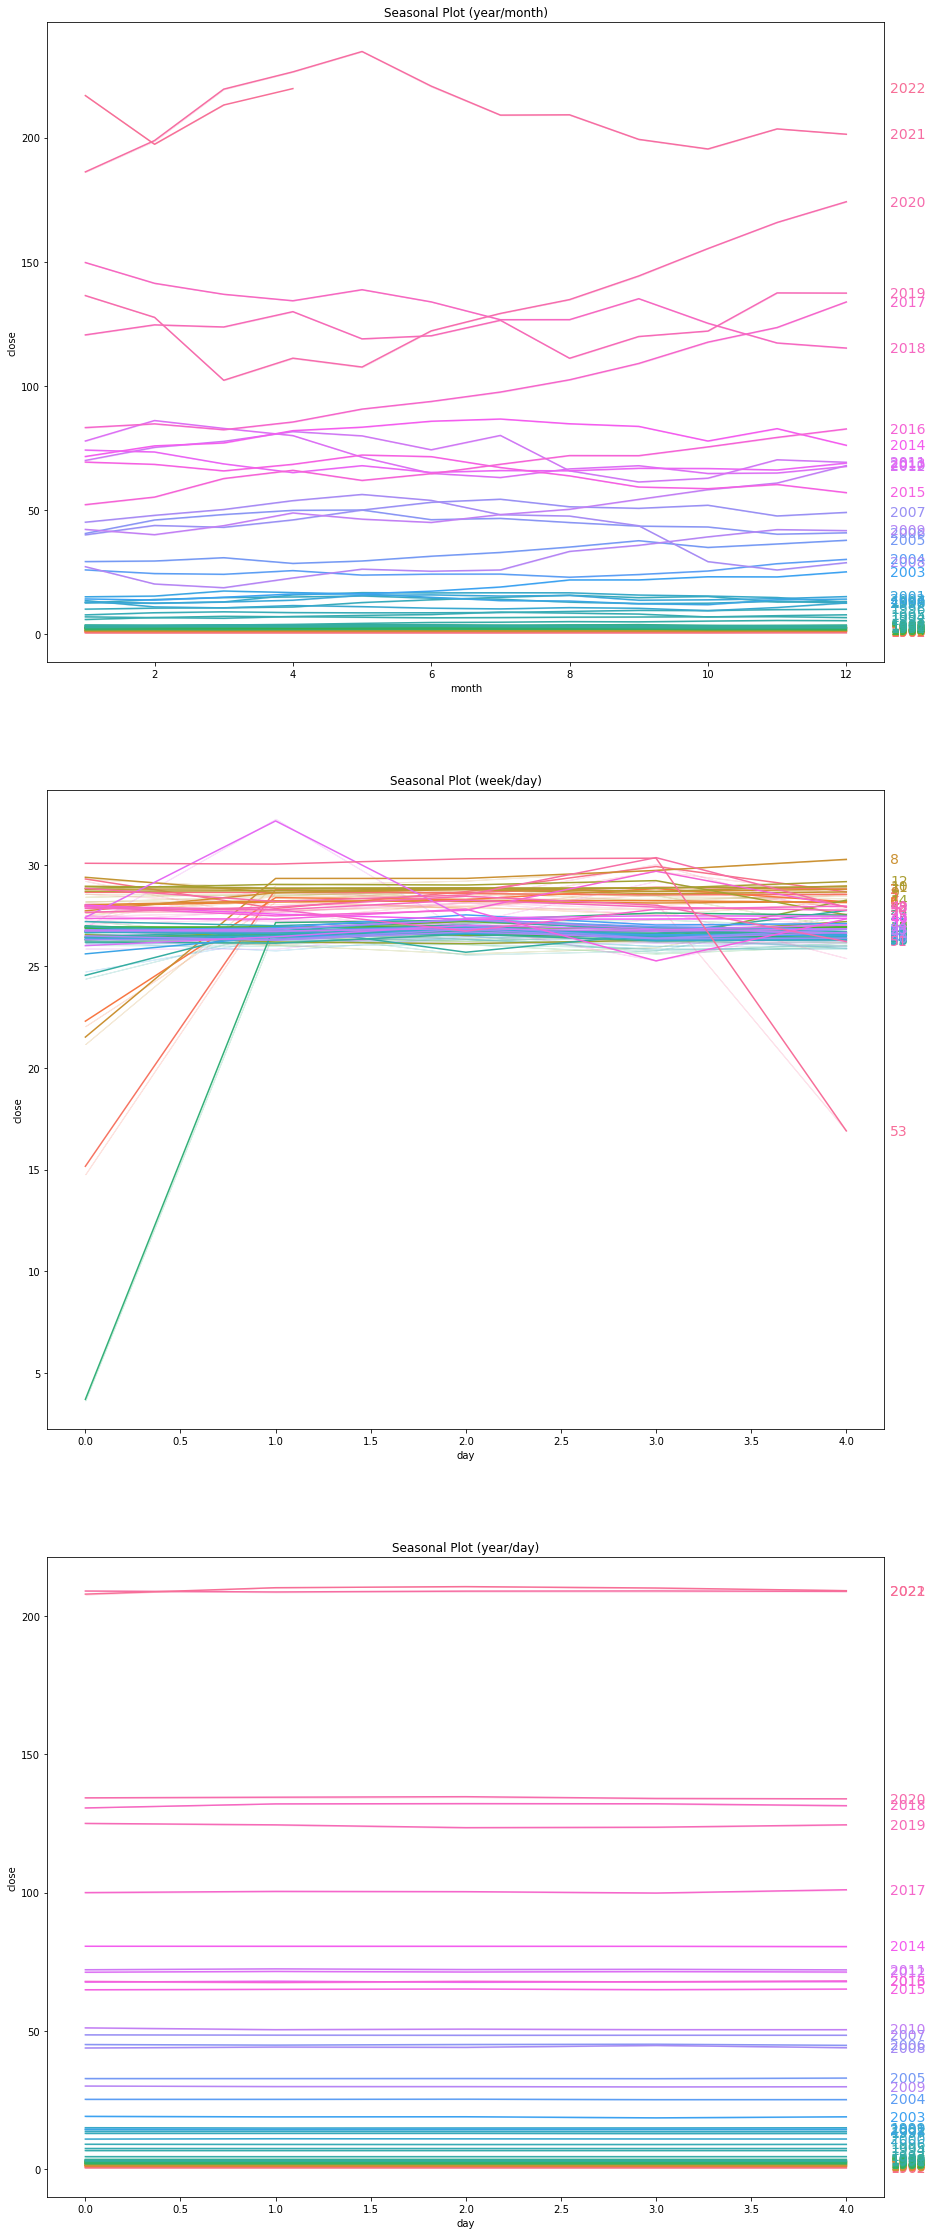

In [6]:
stockDataFrame['year'] = stockDataFrame.index.year
stockDataFrame['month'] = stockDataFrame.index.month
stockDataFrame['week'] = stockDataFrame.index.week
stockDataFrame['day'] = stockDataFrame.index.dayofweek

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(15, 40))
seasonal_plot(stockDataFrame, y='close', period='year', freq='month', ax = ax0);
seasonal_plot(stockDataFrame, y='close', period='week', freq='day', ax = ax1);
seasonal_plot(stockDataFrame, y='close', period='year', freq='day', ax = ax2);


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

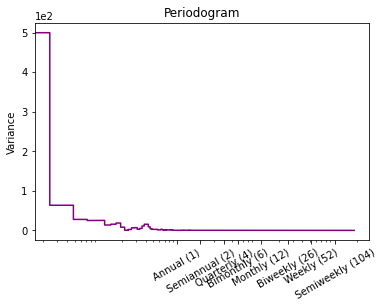

In [7]:
plot_periodogram(stockDataFrame['close'])

In [8]:
# Fresh Pull
stockDataFrame = restructData('CAT', dump, filter = '2000-01-01')


Text(0.5, 1.0, 'CAT')

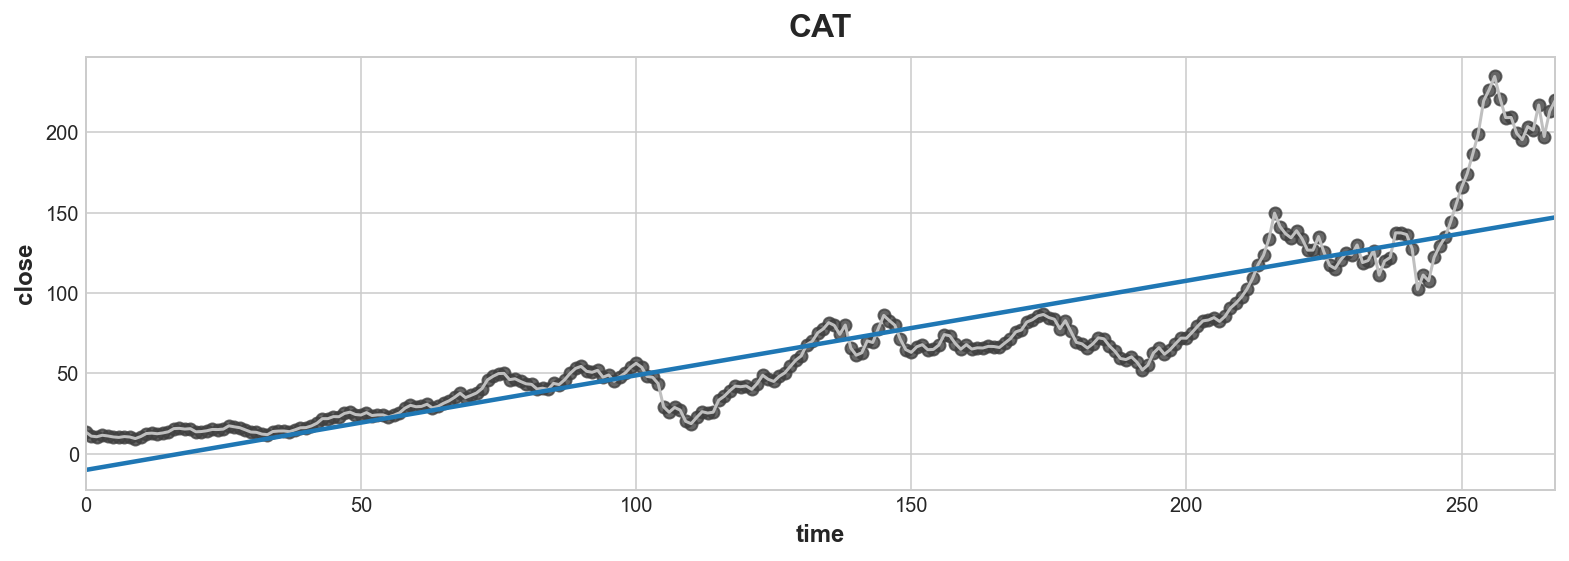

In [9]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('time', 'close', data=stockDataFrame, color='0.75')
ax = sns.regplot(x='time', y='close', data=stockDataFrame, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title(myTicker)

In [10]:
stockDataFrame['lag_1'] = stockDataFrame['close'].shift(1)
# stockDataFrame = stockDataFrame.reindex(columns=['close', 'lag_1', 'time'])

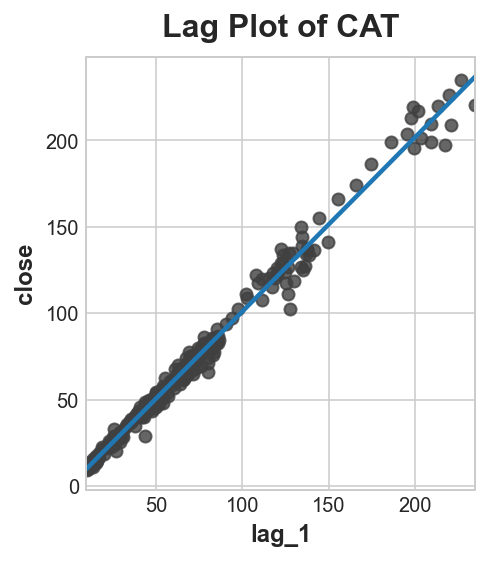

In [11]:
# Plot against Lag
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='close', data=stockDataFrame, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of ' + myTicker);

### Trend

In [12]:
# Training data
X = stockDataFrame.loc[:, ['time']]  # features
y = stockDataFrame.loc[:, 'close']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


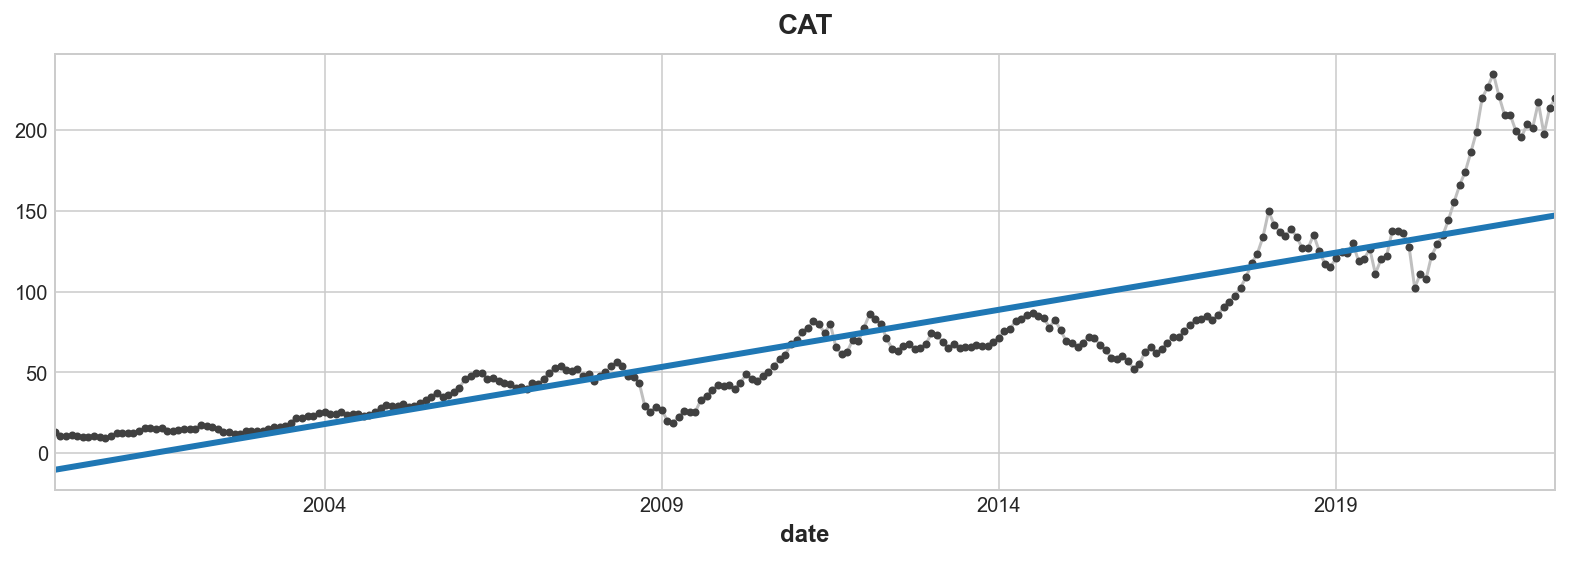

In [13]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title(myTicker);

In [14]:
# Create Model with Lagged Training Data
X = stockDataFrame.loc[:, ['lag_1']]
X.dropna(inplace=True) 
y = stockDataFrame.loc[:, 'close']  # create the target
y, X = y.align(X, join='inner') # Align with dates

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

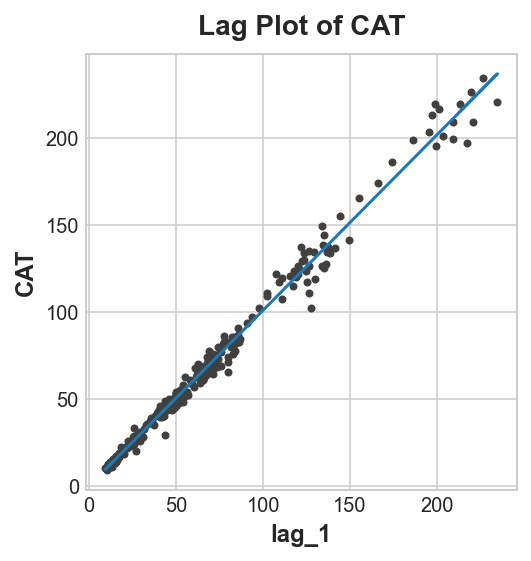

In [15]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel(myTicker)
ax.set_xlabel('lag_1')
ax.set_title('Lag Plot of ' + myTicker);

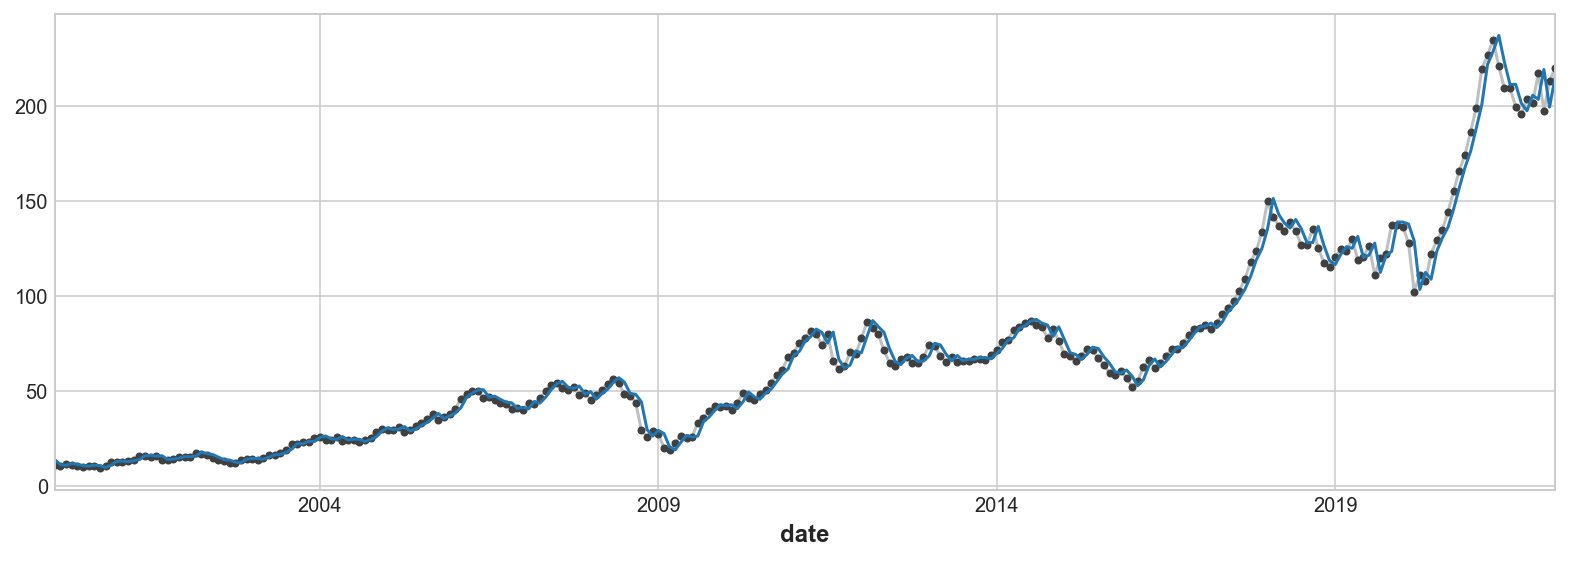

In [16]:
ax = y.plot(**plot_params)
ax = y_pred.plot() # Training w/ Lag of Closing Price

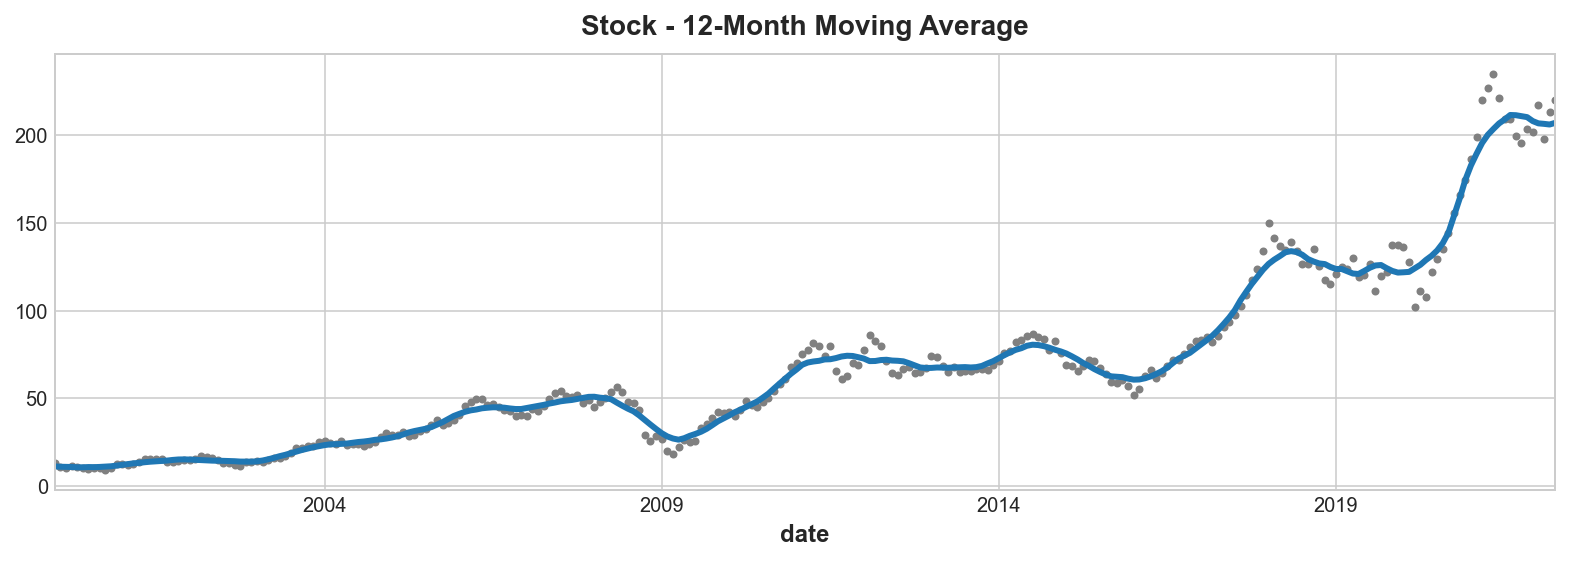

In [17]:
# Create Moving Average
moving_average = stockDataFrame['close'].rolling(
    window=12,       # 12-month window since monthly observations
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = stockDataFrame['close'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Stock - 12-Month Moving Average", legend=False,
);

In [18]:
dp = DeterministicProcess(
    index=stockDataFrame.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X

,const,trend,trend_squared
date,,,
2000-01-31,1.0,1.0,1.0
2000-02-29,1.0,2.0,4.0
2000-03-31,1.0,3.0,9.0
2000-04-30,1.0,4.0,16.0
2000-05-31,1.0,5.0,25.0
...,...,...,...
2021-12-31,1.0,264.0,69696.0
2022-01-31,1.0,265.0,70225.0
2022-02-28,1.0,266.0,70756.0


In [19]:
# Use Deterministic Data for Training 
y = stockDataFrame["close"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

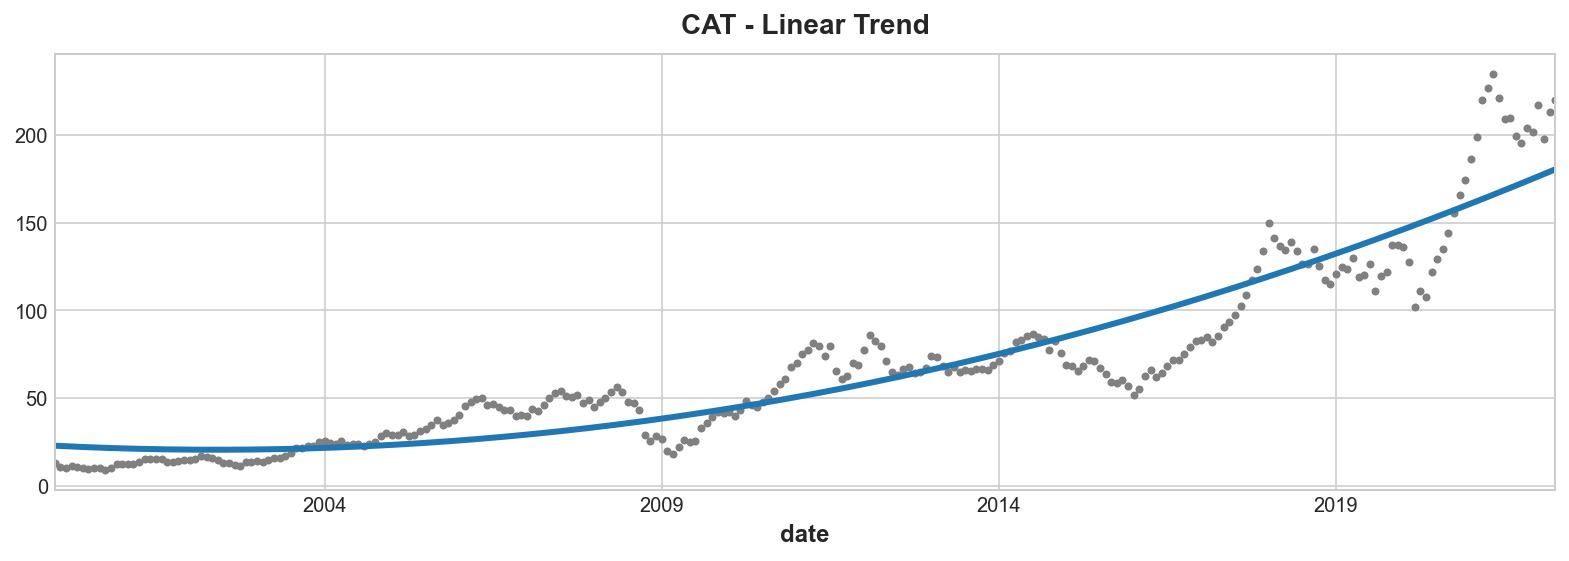

In [20]:
ax = stockDataFrame['close'].plot(style=".", color="0.5", title= myTicker + " - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [21]:
mySteps = 24
futureDateLst = []
# Derive Future Dates
for i in range(1, mySteps + 1):
    futureDateLst.append(stockDataFrame.index[-1] + relativedelta(months=+i))

X= dp.out_of_sample(steps= mySteps)
X.index = futureDateLst
y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-05-30    181.585029
2022-06-30    182.931475
2022-07-30    184.283533
2022-08-30    185.641204
2022-09-30    187.004488
dtype: float64

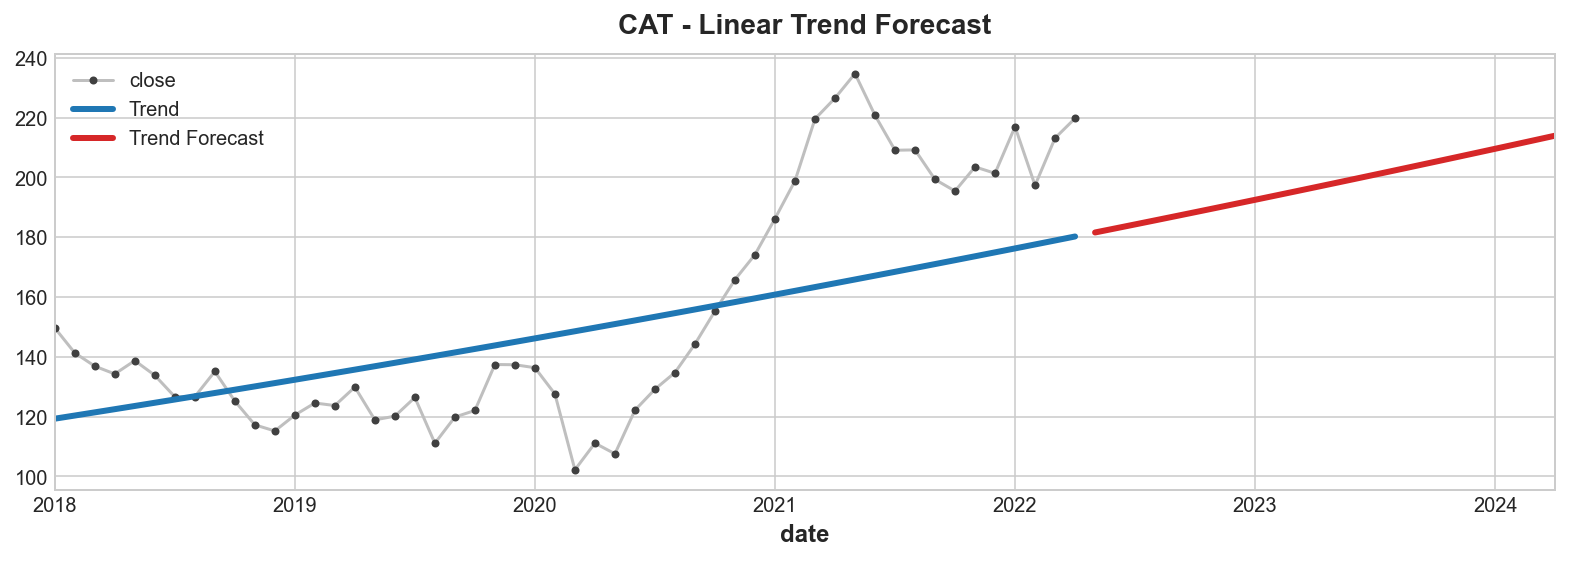

In [22]:
ax = stockDataFrame["2018-01-31":]['close'].plot(title= myTicker + " - Linear Trend Forecast", **plot_params)
ax = y_pred["2018-01-31":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

### Time Series as Features

In [23]:
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def make_lags(ts, lags):
    return pd.concat(
        {
            f'lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)



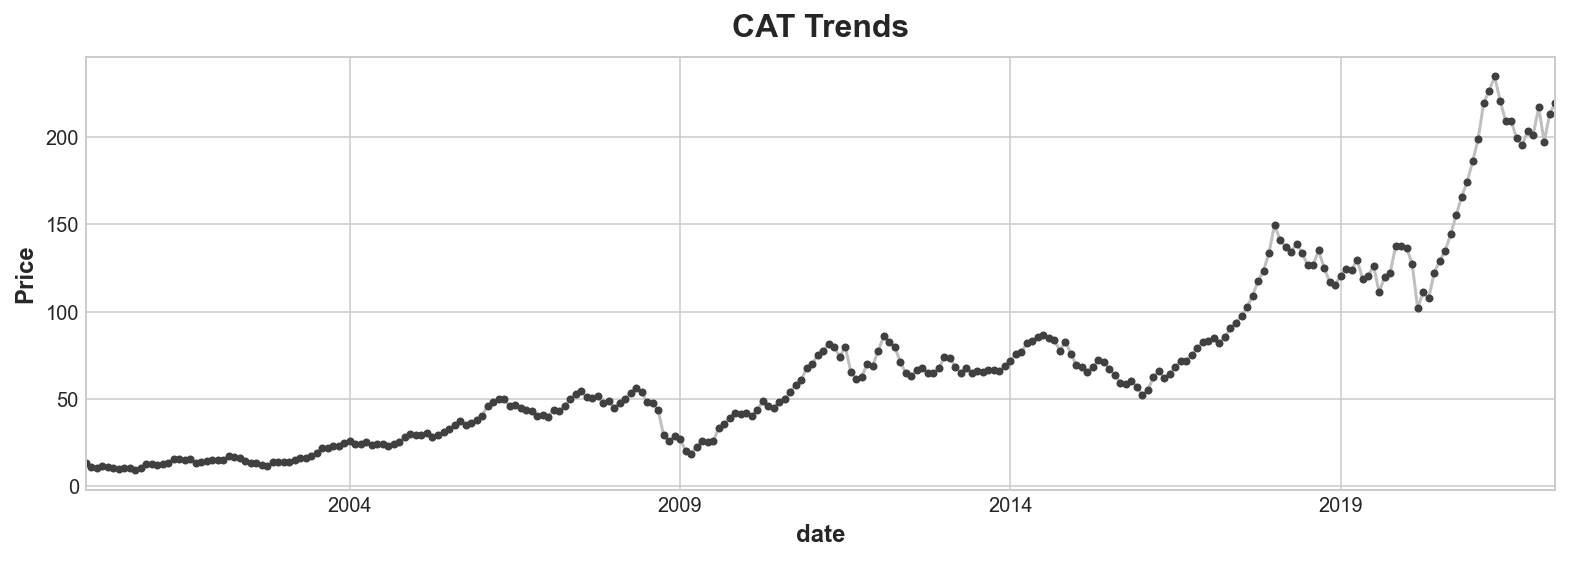

In [24]:
ax = stockDataFrame.close.plot(title= myTicker + ' Trends', **plot_params)
_ = ax.set(ylabel="Price")


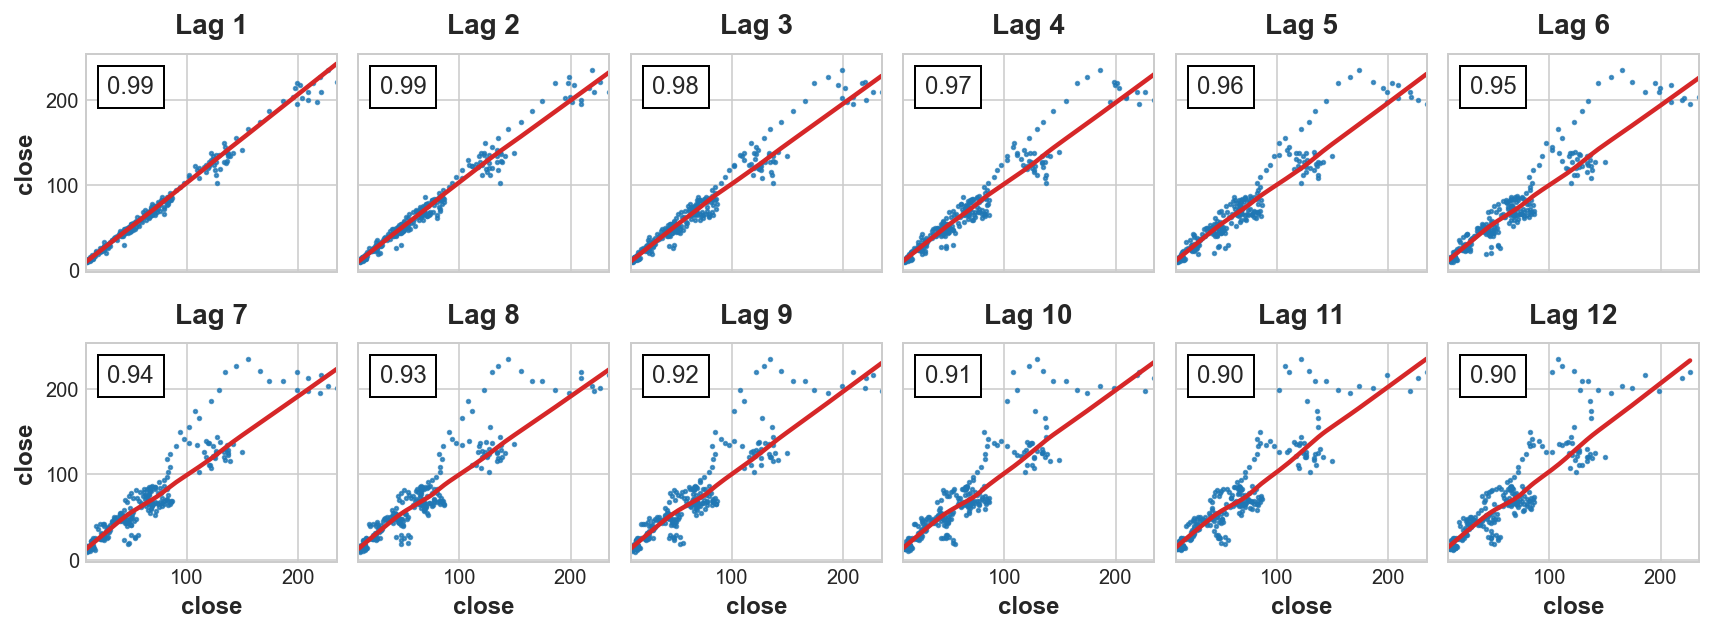

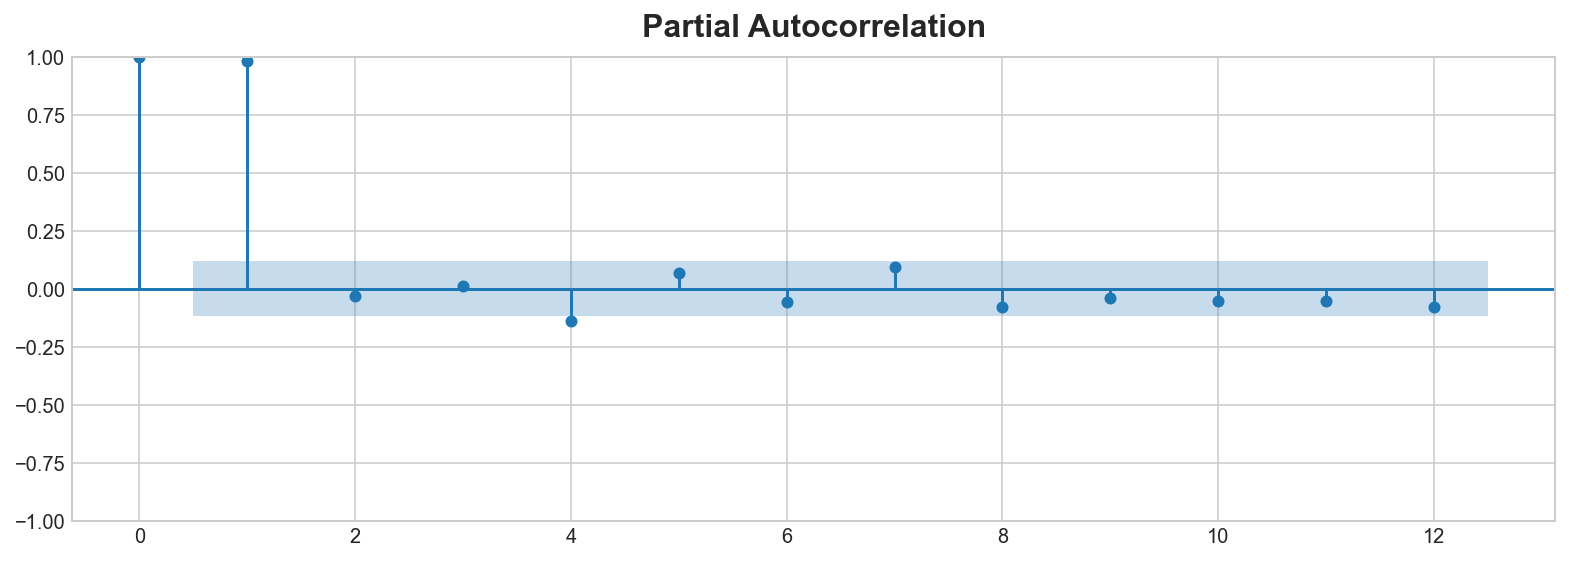

In [25]:
_ = plot_lags(stockDataFrame.close, lags=12, nrows=2)
_ = plot_pacf(stockDataFrame.close, lags=12)

In [26]:
X = make_lags(stockDataFrame.close, lags=4)
X = X.fillna(0.0)
X

,lag_1,lag_2,lag_3,lag_4
date,,,,
2000-01-31,0.000000,0.000000,0.000000,0.000000
2000-02-29,13.441836,0.000000,0.000000,0.000000
2000-03-31,10.877913,13.441836,0.000000,0.000000
2000-04-30,10.490772,10.877913,13.441836,0.000000
2000-05-31,11.428132,10.490772,10.877913,13.441836
...,...,...,...,...
2021-12-31,203.527198,195.437477,199.307556,209.205049
2022-01-31,201.380130,203.527198,195.437477,199.307556
2022-02-28,216.961189,201.380130,203.527198,195.437477


In [27]:
# Create target series and data splits
y = stockDataFrame.close.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

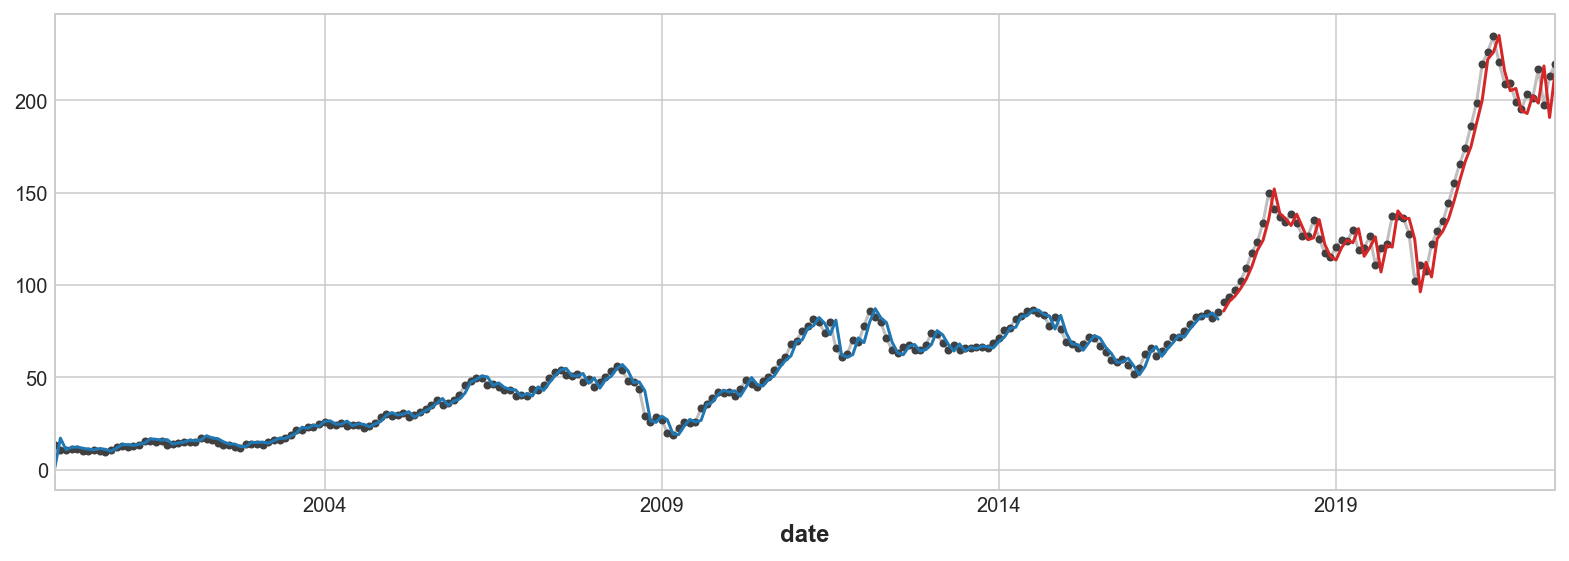

In [28]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

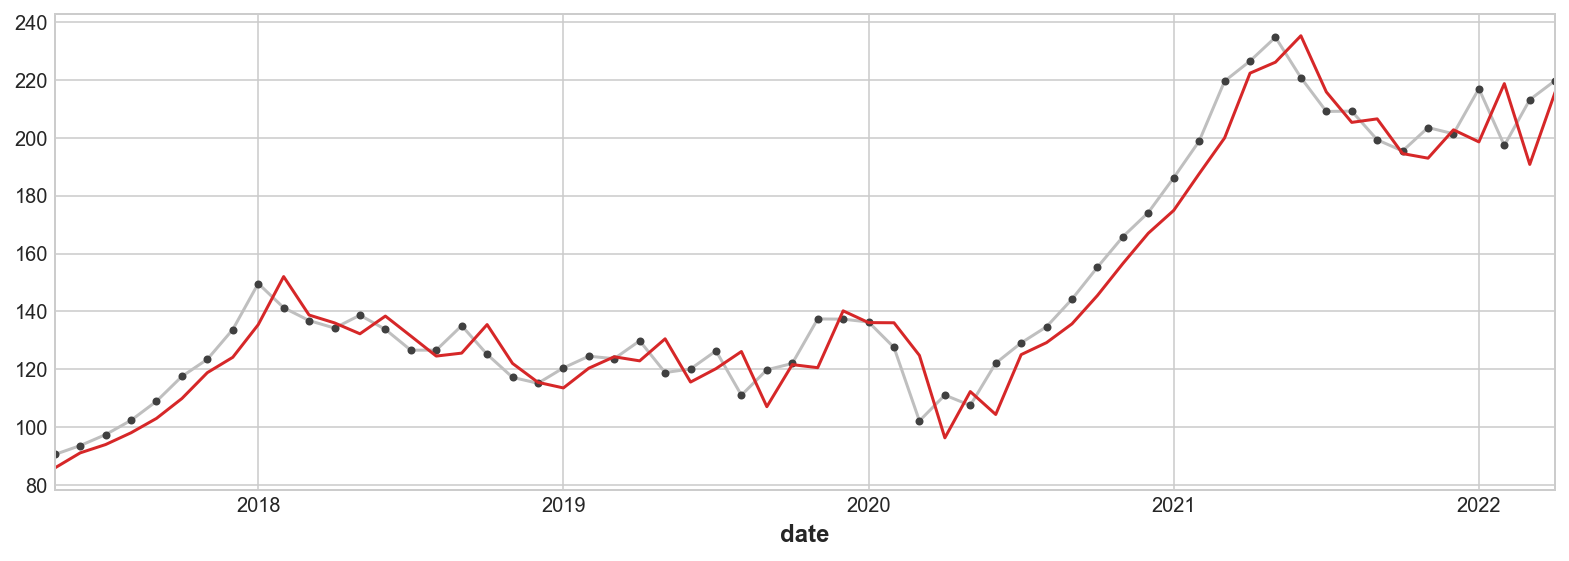

In [29]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

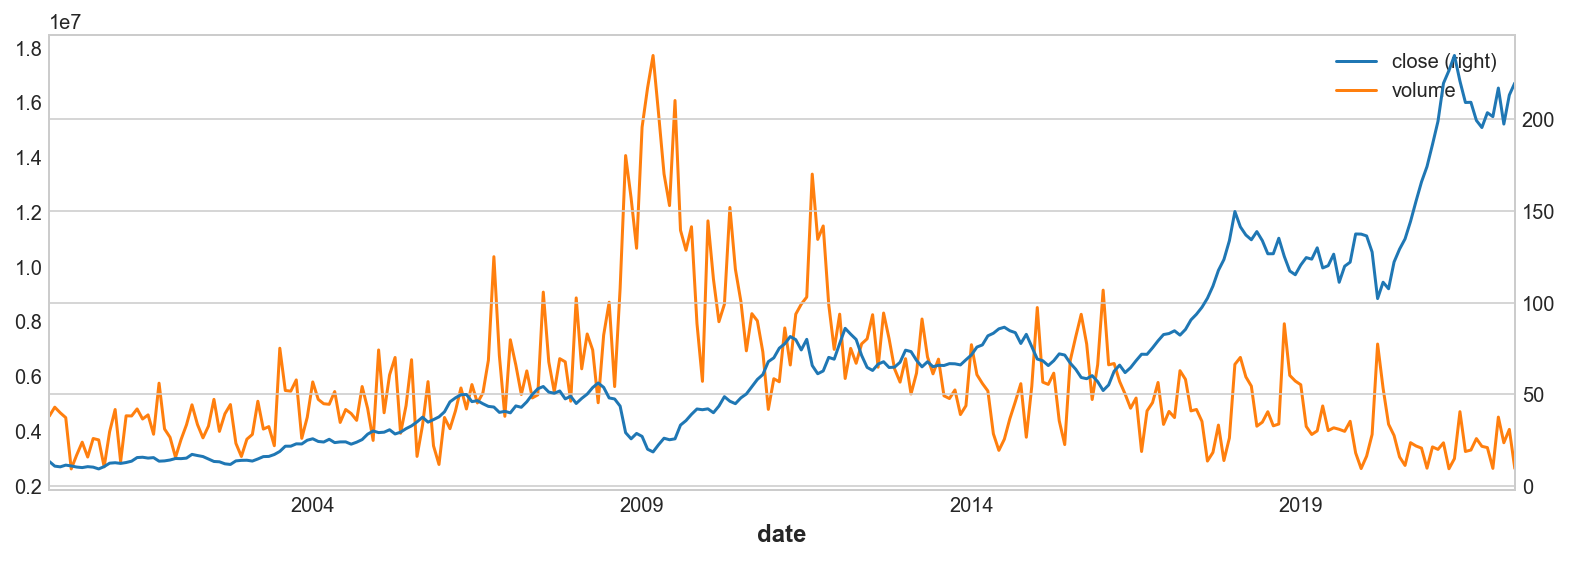

In [30]:
ax = stockDataFrame.plot(
    y=["close", "volume"],
    secondary_y="close",
)

In [31]:
search_terms = ["volume", "dividends"]

In [32]:
# Create three lags for each search term
X0 = make_lags(stockDataFrame[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(stockDataFrame['close'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

In [33]:
X

,"(lag_1, volume)","(lag_1, dividends)","(lag_2, volume)","(lag_2, dividends)","(lag_3, volume)","(lag_3, dividends)",lag_1,lag_2,lag_3,lag_4
date,,,,,,,,,,
2000-01-31,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2000-02-29,4.531190e+06,0.008125,0.000000e+00,0.000000,0.000000e+00,0.000000,13.441836,0.000000,0.000000,0.000000
2000-03-31,4.859500e+06,0.000000,4.531190e+06,0.008125,0.000000e+00,0.000000,10.877913,13.441836,0.000000,0.000000
2000-04-30,4.654652e+06,0.000000,4.859500e+06,0.000000,4.531190e+06,0.008125,10.490772,10.877913,13.441836,0.000000
2000-05-31,4.477295e+06,0.008553,4.654652e+06,0.000000,4.859500e+06,0.000000,11.428132,10.490772,10.877913,13.441836
...,...,...,...,...,...,...,...,...,...,...
2021-12-31,3.383595e+06,0.000000,3.429824e+06,0.052857,3.712214e+06,0.000000,203.527198,195.437477,199.307556,209.205049
2022-01-31,2.624773e+06,0.000000,3.383595e+06,0.000000,3.429824e+06,0.052857,201.380130,203.527198,195.437477,199.307556
2022-02-28,4.497505e+06,0.055500,2.624773e+06,0.000000,3.383595e+06,0.000000,216.961189,201.380130,203.527198,195.437477


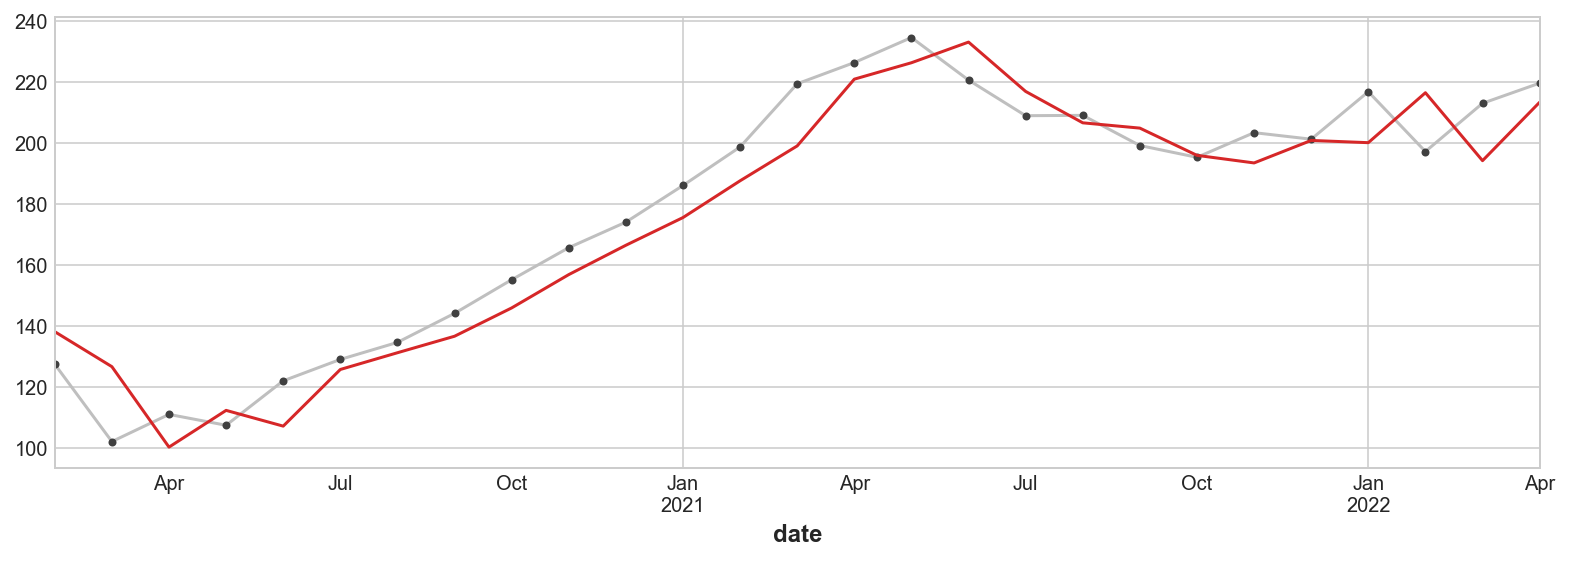

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

# Training Data View
# ax = y_train.plot(**plot_params)
# ax = y_pred.plot(ax=ax)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

### Hybrid Modeling

### Forecasting with Machine Learning

#### Multioutput Model
Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

In [35]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)



In [36]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [37]:
stockDataFrame = restructData('CAT', dump, filter = '2000-01-01')

In [38]:
stockDataFrame

,open,high,low,close,volume,dividends,stock_splits,time
date,,,,,,,,
2000-01-31,13.553498,13.840766,13.306227,13.441836,4.531190e+06,0.008125,0.0,0
2000-02-29,10.971192,11.167340,10.702688,10.877913,4.859500e+06,0.000000,0.0,1
2000-03-31,10.453627,10.766706,10.295951,10.490772,4.654652e+06,0.000000,0.0,2
2000-04-30,11.424424,11.753570,11.228441,11.428132,4.477295e+06,0.008553,0.0,3
2000-05-31,11.003374,11.203116,10.829999,10.988993,2.604418e+06,0.000000,0.0,4
...,...,...,...,...,...,...,...,...
2021-12-31,201.249852,203.282715,199.693313,201.380130,2.624773e+06,0.000000,0.0,263
2022-01-31,216.860690,219.726788,213.398924,216.961189,4.497505e+06,0.055500,0.0,264
2022-02-28,197.423158,199.786840,195.298945,197.334739,3.560884e+06,0.000000,0.0,265


In [39]:
# Four weeks of lag features based on Partial Correlation and Lag Plots from Prior Section
y = stockDataFrame.close.copy()
X = make_lags(y, lags=4).fillna(0.0)

In [40]:
# 12 Month Forecast 
y = make_multistep_target(y, steps=12).dropna()

In [41]:
# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

In [42]:
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12
date,,,,,,,,,,,,
2000-01-31,13.441836,10.877913,10.490772,11.428132,10.988993,10.372589,10.080321,10.595445,10.325624,9.355292,10.636147,12.488798
2000-02-29,10.877913,10.490772,11.428132,10.988993,10.372589,10.080321,10.595445,10.325624,9.355292,10.636147,12.488798,12.733577
2000-03-31,10.490772,11.428132,10.988993,10.372589,10.080321,10.595445,10.325624,9.355292,10.636147,12.488798,12.733577,12.365492
2000-04-30,11.428132,10.988993,10.372589,10.080321,10.595445,10.325624,9.355292,10.636147,12.488798,12.733577,12.365492,12.847656
2000-05-31,10.988993,10.372589,10.080321,10.595445,10.325624,9.355292,10.636147,12.488798,12.733577,12.365492,12.847656,13.583861
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31,186.205980,198.837111,219.554377,226.516814,234.721036,220.770408,209.089100,209.205049,199.307556,195.437477,203.527198,201.380130
2021-02-28,198.837111,219.554377,226.516814,234.721036,220.770408,209.089100,209.205049,199.307556,195.437477,203.527198,201.380130,216.961189
2021-03-31,219.554377,226.516814,234.721036,220.770408,209.089100,209.205049,199.307556,195.437477,203.527198,201.380130,216.961189,197.334739


In [43]:
X

,lag_1,lag_2,lag_3,lag_4
date,,,,
2000-01-31,0.000000,0.000000,0.000000,0.000000
2000-02-29,13.441836,0.000000,0.000000,0.000000
2000-03-31,10.877913,13.441836,0.000000,0.000000
2000-04-30,10.490772,10.877913,13.441836,0.000000
2000-05-31,11.428132,10.490772,10.877913,13.441836
...,...,...,...,...
2021-01-31,174.178109,165.811783,155.293049,144.262524
2021-02-28,186.205980,174.178109,165.811783,155.293049
2021-03-31,198.837111,186.205980,174.178109,165.811783


In [44]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train) # Train model

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns) 
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [45]:
X_test

,lag_1,lag_2,lag_3,lag_4
date,,,,
2019-04-30,123.694851,124.551290,120.508974,115.201959
2019-05-31,129.873666,123.694851,124.551290,120.508974
2019-06-30,118.906641,129.873666,123.694851,124.551290
2019-07-31,120.150190,118.906641,129.873666,123.694851
2019-08-31,126.398616,120.150190,118.906641,129.873666
2019-09-30,111.089195,126.398616,120.150190,118.906641
2019-10-31,119.851280,111.089195,126.398616,120.150190
2019-11-30,122.044922,119.851280,111.089195,126.398616
2019-12-31,137.425518,122.044922,119.851280,111.089195


In [46]:
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12
date,,,,,,,,,,,,
2019-04-30,123.618576,124.687532,124.873753,123.913114,123.497271,123.504167,123.680102,123.706222,123.980303,124.226641,124.568906,125.018439
2019-05-31,131.843437,132.538899,132.247280,132.504509,133.119795,131.895211,131.633971,131.593911,132.086103,132.513453,132.758714,133.028506
2019-06-30,115.522501,115.706029,116.161912,114.748752,113.523979,115.233989,115.827665,115.990573,116.166527,116.412636,116.987398,117.144978
2019-07-31,121.781082,122.369096,120.389073,119.670437,121.874440,121.585863,121.425299,121.154914,121.456844,122.089027,122.668001,123.594723
2019-08-31,126.960486,125.512142,126.206011,128.940002,128.984671,127.715889,127.344736,127.685634,128.609199,129.256243,129.488790,128.452854
2019-09-30,106.788193,107.290282,107.576724,105.231404,103.904903,106.421987,107.271371,107.409478,107.417295,107.610170,108.308077,108.796032
2019-10-31,123.768609,124.237214,121.871378,122.260581,125.473717,123.939487,123.390894,123.079334,123.584995,124.374218,124.847307,125.713541
2019-11-30,120.661874,118.873041,120.763340,123.611791,122.200038,121.621760,121.539230,122.127644,123.072952,123.587619,123.796585,122.305069
2019-12-31,141.957484,143.525702,143.743827,144.520510,145.006846,142.192389,141.613967,141.553336,142.158905,142.469731,142.403145,142.700181


In [47]:
from sklearn.metrics import mean_squared_error

Train RMSE: 11.32
Test RMSE: 37.54


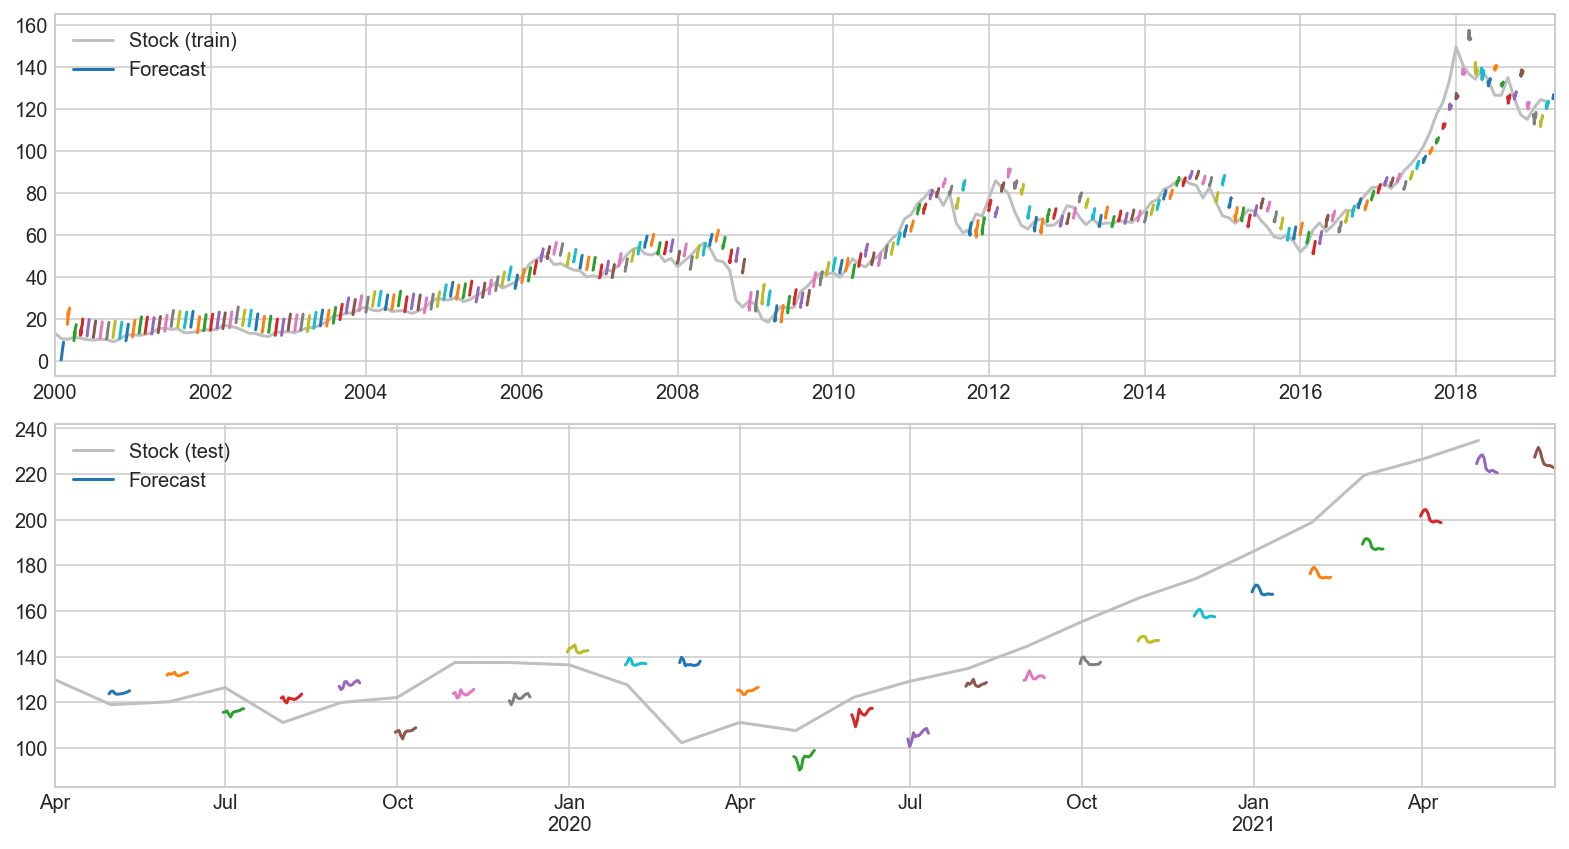

In [48]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False) 
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = stockDataFrame.close[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Stock (train)', 'Forecast'])
ax2 = stockDataFrame.close[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Stock (test)', 'Forecast'])

In [49]:
# Trying out extended forecasts
stockDataFrame = restructData('CAT', dump, filter = '2000-01-01')
y = stockDataFrame.close.copy()
X = make_lags(y, lags=4).fillna(0.0)
# 12 Month Forecast 
y = make_multistep_target(y, steps=12)
y_pred = pd.DataFrame(model.predict(X.tail(5)), index=X.tail(5).index, columns=y.columns)

In [51]:
y_pred

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12
date,,,,,,,,,,,,
2021-12-31,204.578498,202.764714,202.121460,204.501105,205.108229,202.811086,201.763577,201.530578,202.359303,202.999467,203.096573,201.825146
2022-01-31,199.435311,198.970332,199.507212,199.371039,197.702803,197.144618,196.826249,196.661524,197.048500,197.216281,197.341810,196.504795
2022-02-28,221.333047,222.286013,221.281320,221.730537,222.549334,218.949089,217.740456,217.133773,217.645159,217.946049,217.767149,217.688876
2022-03-31,190.448790,190.452177,191.455016,188.473600,184.948089,187.341770,187.929329,187.794429,187.659644,187.503097,187.932484,187.496912
2022-04-30,219.495826,220.841531,216.957396,216.304940,220.194063,216.641655,215.202890,214.098203,214.397965,215.018656,215.161106,216.238358


In [52]:
y_pred[y_pred.index == '2022-04-30'].index[0]

Timestamp('2022-04-30 00:00:00')

In [56]:
mySteps = 12
futureDateLst = []
# Derive Future Dates
for i in range(1, mySteps + 1):
    futureDateLst.append(y_pred[y_pred.index == '2022-04-30'].index[0] + relativedelta(months=+i))

temp = y_pred[y_pred.index == '2022-04-30'].T # Transpose
temp.index = futureDateLst

l = stockDataFrame['close'].append(temp['2022-04-30'])

<AxesSubplot:>

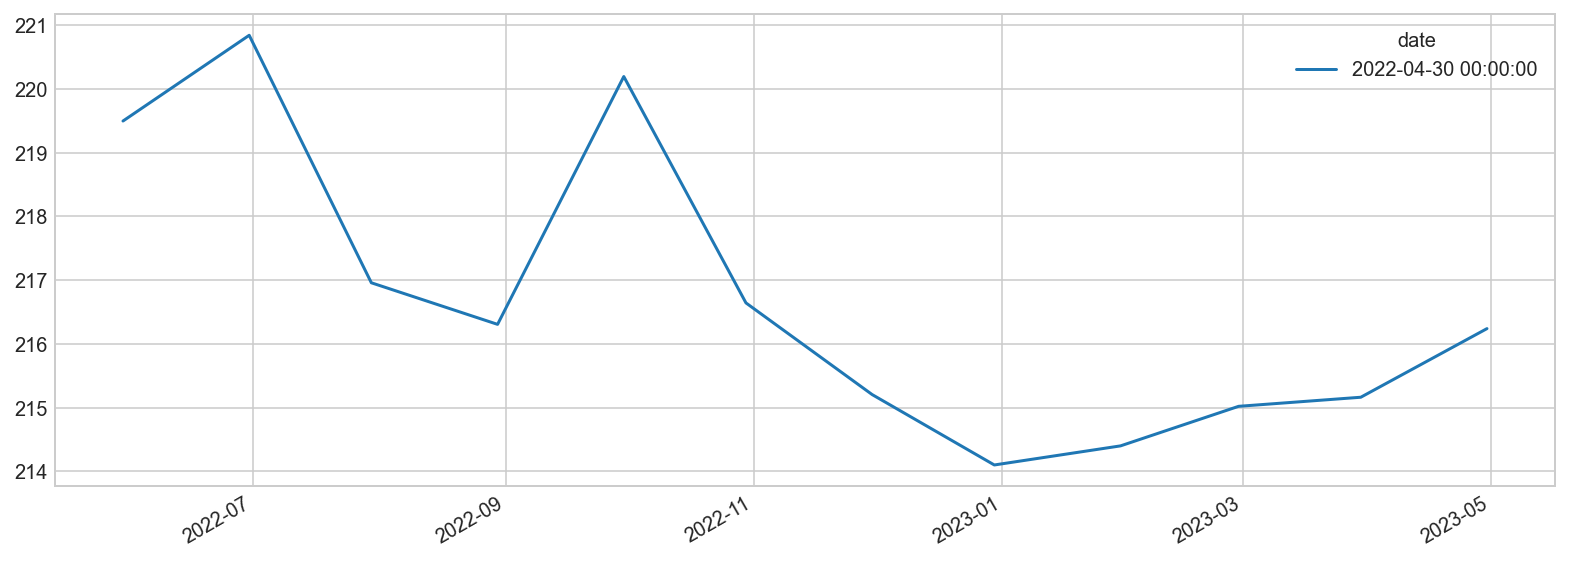

In [57]:
temp.plot()

<AxesSubplot:>

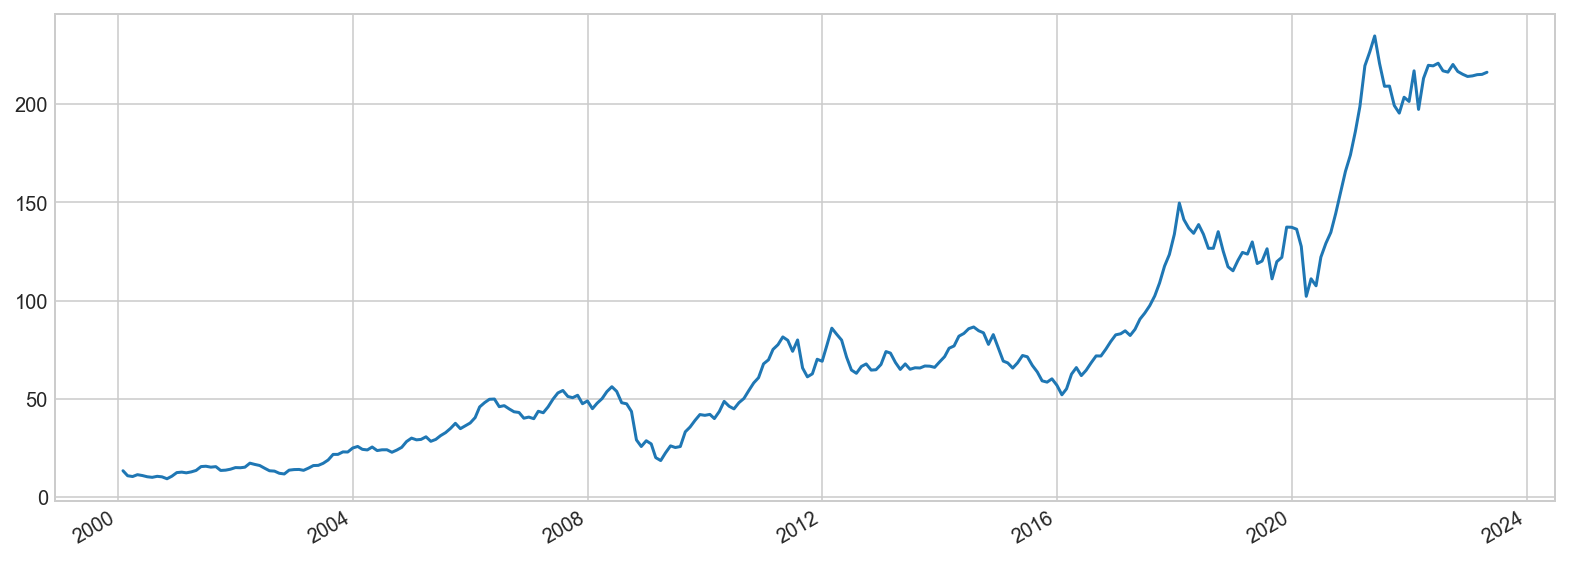

In [58]:
l.plot()

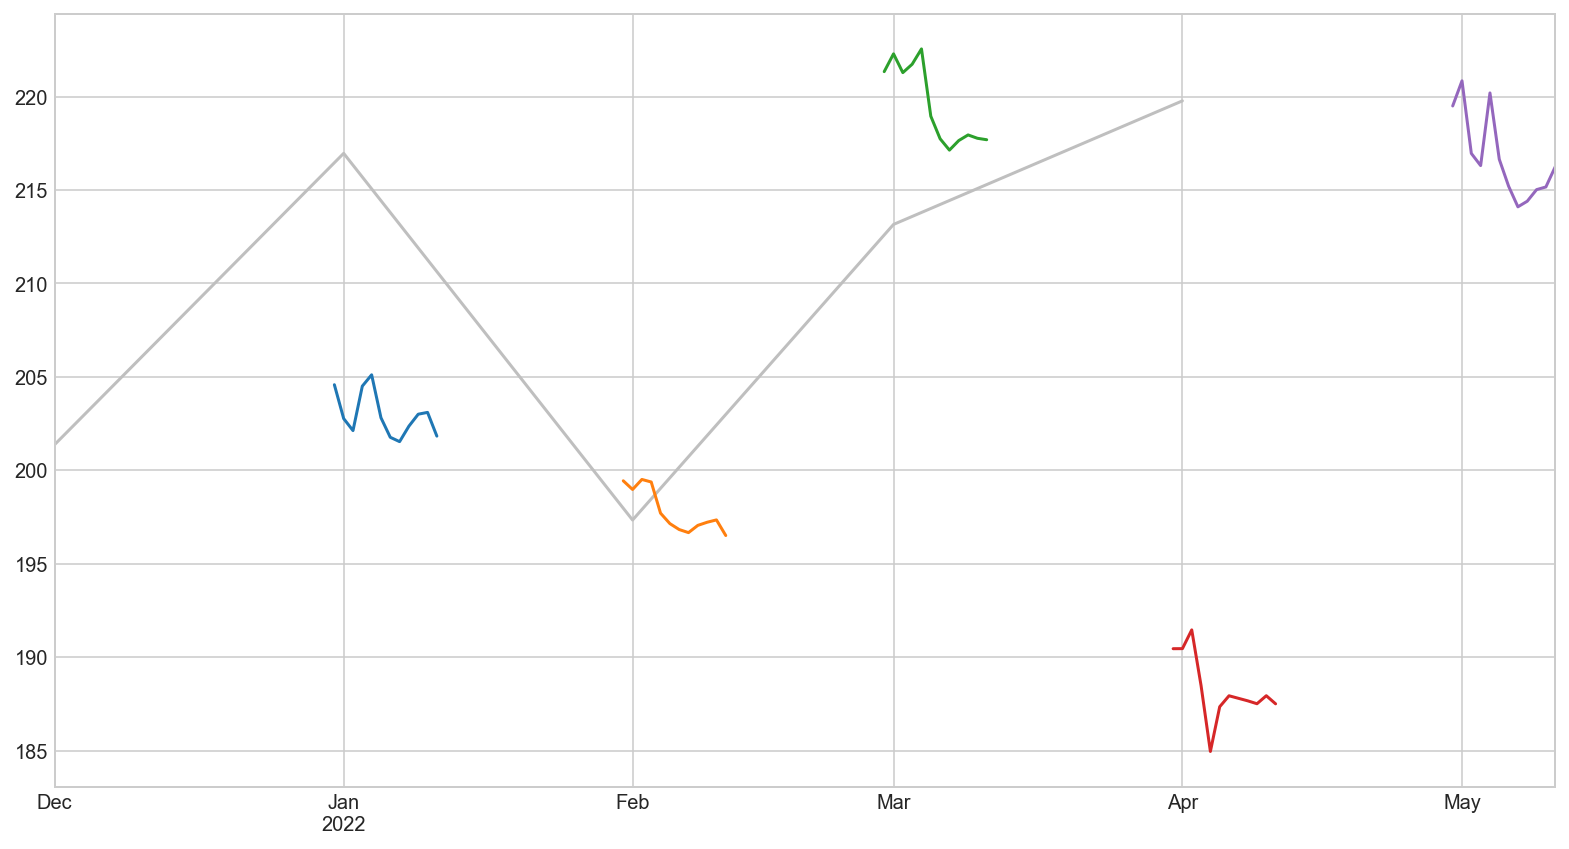

In [59]:
# Doesn't seem to get plotted properly... maybe a bug here?
palette = dict(palette='husl', n_colors=64)
fig, (ax1) = plt.subplots(1, 1, figsize=(11, 6))
ax1 = stockDataFrame.close[y_pred.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_pred, ax=ax1, palette_kwargs=palette)
_ = ax2.legend(['Stock (test)', 'Forecast'])

#### Direct Strategy
Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [99]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [101]:
X_test

,lag_1,lag_2,lag_3,lag_4
date,,,,
2019-03-31,124.551291,120.508976,115.201959,117.243528
2019-04-30,123.694857,124.551291,120.508976,115.201959
2019-05-31,129.873661,123.694857,124.551291,120.508976
2019-06-30,118.906642,129.873661,123.694857,124.551291
2019-07-31,120.150193,118.906642,129.873661,123.694857
2019-08-31,126.398622,120.150193,118.906642,129.873661
2019-09-30,111.089194,126.398622,120.150193,118.906642
2019-10-31,119.851281,111.089194,126.398622,120.150193
2019-11-30,122.044920,119.851281,111.089194,126.398622


In [102]:
y_test

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8,y_step_9,y_step_10,y_step_11,y_step_12
date,,,,,,,,,,,,
2019-03-31,123.694857,129.873661,118.906642,120.150193,126.398622,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337
2019-04-30,129.873661,118.906642,120.150193,126.398622,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270
2019-05-31,118.906642,120.150193,126.398622,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654
2019-06-30,120.150193,126.398622,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058
2019-07-31,126.398622,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058,122.133792
2019-08-31,111.089194,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058,122.133792,129.152508
2019-09-30,119.851281,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058,122.133792,129.152508,134.736497
2019-10-31,122.044920,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058,122.133792,129.152508,134.736497,144.262522
2019-11-30,137.425512,137.350531,136.352442,127.576337,102.211270,111.124654,107.555058,122.133792,129.152508,134.736497,144.262522,155.293049


Train RMSE: 0.12
Test RMSE: 52.85


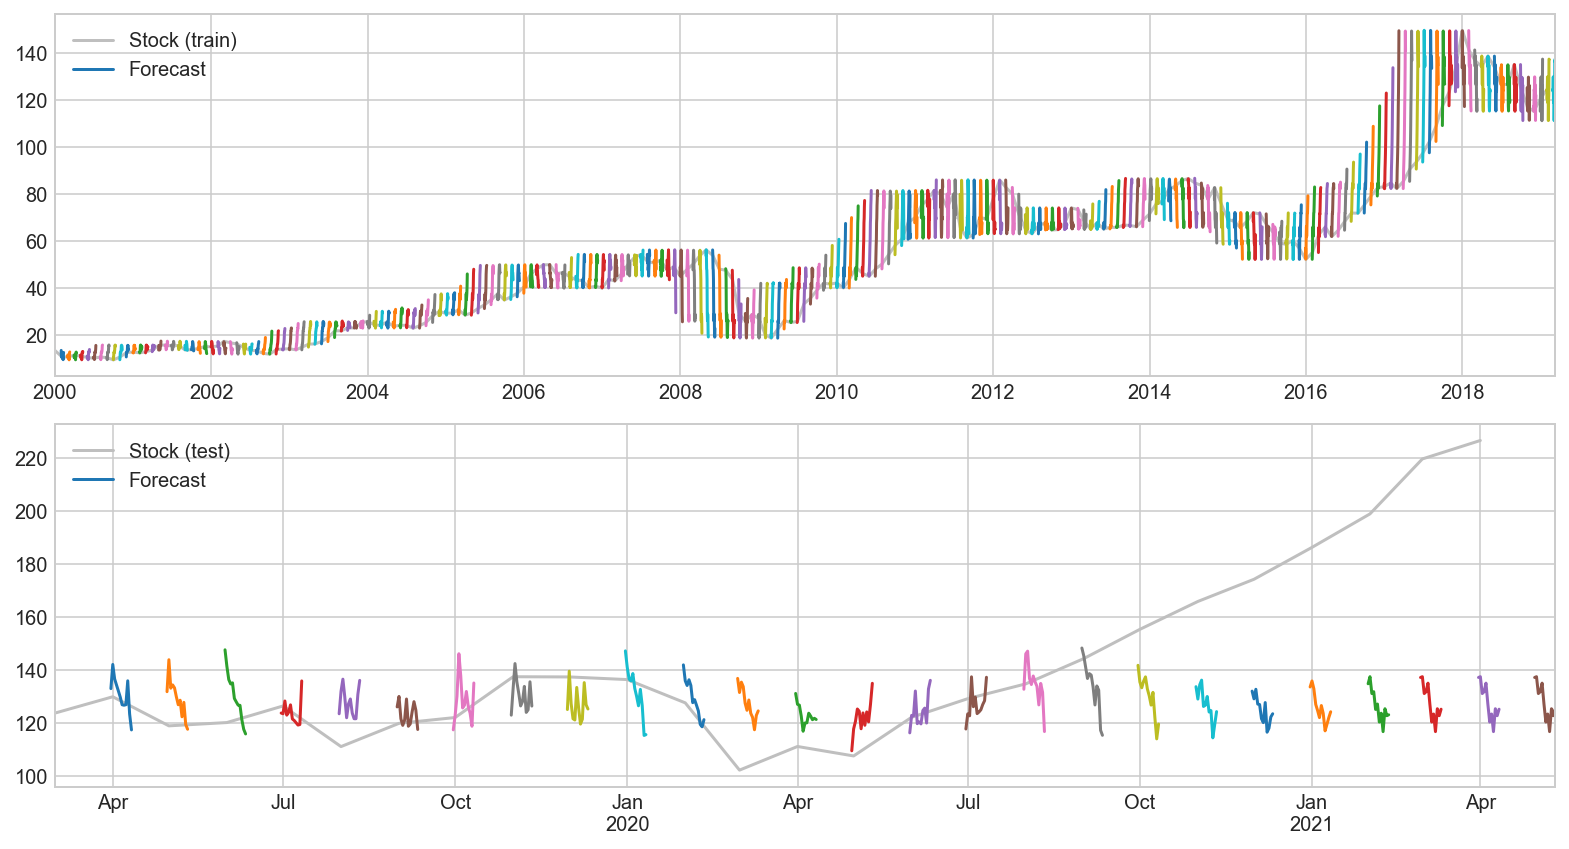

In [100]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False) 
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = stockDataFrame.close[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Stock (train)', 'Forecast'])
ax2 = stockDataFrame.close[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Stock (test)', 'Forecast'])

In [ ]:
https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff